## Evaluations of Bering Sea ADCP Data 

### Example step by step for one site

In [25]:
from erddapy import ERDDAP
import pandas as pd
import numpy as np
import xarray as xr
import datetime

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.dates import MonthLocator, DateFormatter
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
from matplotlib.ticker import NullFormatter  # useful for `logit` scale

server_url='http://akutan.pmel.noaa.gov:8080/erddap'
dataset = 'ADCP_Mooring_19bsp8a_final'


e = ERDDAP(server=server_url)

e.constraints = None
e.protocol = 'griddap'

opendap_url = e.get_download_url(
    dataset_id=dataset,
    response='opendap',
)

print(opendap_url)

http://akutan.pmel.noaa.gov:8080/erddap/griddap/ADCP_Mooring_19bsp8a_final


In [12]:
from netCDF4 import Dataset

with Dataset(opendap_url) as nc:
    print(nc.summary)

QC'd (final) Gridded ADCP Vel/Ein Data from 19CKP-1A


In [13]:
e.dataset_id=dataset
e.response = 'nc'
ds = e.to_xarray(decode_times=True)

get second to last index (so 2 bin from bottom)

In [14]:
depth_curr = ds.isel(depth=ds.depth.size-2)

In [15]:
depth_curr

<xarray.Dataset>
Dimensions:          (latitude: 1, longitude: 1, time: 8418)
Coordinates:
  * latitude         (latitude) float64 62.2
  * longitude        (longitude) float64 534.7
  * time             (time) datetime64[ns] 2019-09-24 ... 2020-09-08T17:00:00
    depth            float64 52.0
Data variables:
    u_curr_comp      (latitude, longitude, time) float64 ...
    v_curr_comp      (latitude, longitude, time) float64 ...
    w_curr_comp      (latitude, longitude, time) float64 ...
    w_curr_comp_err  (latitude, longitude, time) float64 ...
    agc1             (latitude, longitude, time) float64 ...
    agc2             (latitude, longitude, time) float64 ...
    agc3             (latitude, longitude, time) float64 ...
    agc4             (latitude, longitude, time) float64 ...
Attributes: (12/38)
    cdm_data_type:                          Grid
    Conventions:                            COARDS, CF-1.6, ACDD-1.3
    date_created:                           2021-08-06T11:06:20Z
    Easternmost_Easting:                    534.6745
    geospatial_lat_max:                     62.196
    geospatial_lat_min:                     62.196
    ...                                     ...
    summary:                                QC'd (final) Gridded ADCP Vel/Ein...
    time_coverage_end:                      2020-09-08T17:00:00Z
    time_coverage_start:                    2019-09-24T00:00:00Z
    title:                                  QC'd (final) ADCP Vel/Ein Data fr...
    WaterDepth:                             74.0
    Westernmost_Easting:                    534.6745

In [16]:
### final only with filtered data
import sys
try:
    # The insertion index should be 1 because index 0 is this file
    sys.path.insert(1, '/Users/bell/Programs/Python/EcoFOCI_Jupyter_Notebooks/filters')  # the type of path is string
    # because the system path already have the absolute path to folder a
    # so it can recognize file_a.py while searching 
    import lanzcos
except (ModuleNotFoundError, ImportError) as e:
    print("{} fileure".format(type(e)))
else:
    print("Import succeeded")

Import succeeded


In [17]:
depth_curr=depth_curr.dropna(dim='time')
depth_curr

<xarray.Dataset>
Dimensions:          (latitude: 1, longitude: 1, time: 3781)
Coordinates:
  * latitude         (latitude) float64 62.2
  * longitude        (longitude) float64 534.7
  * time             (time) datetime64[ns] 2019-09-24 ... 2020-02-28T12:00:00
    depth            float64 52.0
Data variables:
    u_curr_comp      (latitude, longitude, time) float64 9.647 15.72 ... -2.339
    v_curr_comp      (latitude, longitude, time) float64 15.96 9.337 ... -4.021
    w_curr_comp      (latitude, longitude, time) float64 -0.5 -0.2 ... -0.2 -0.1
    w_curr_comp_err  (latitude, longitude, time) float64 -0.3 0.6 ... 0.1 0.0
    agc1             (latitude, longitude, time) float64 114.0 121.0 ... 134.0
    agc2             (latitude, longitude, time) float64 113.0 120.0 ... 131.0
    agc3             (latitude, longitude, time) float64 116.0 123.0 ... 134.0
    agc4             (latitude, longitude, time) float64 119.0 127.0 ... 139.0
Attributes: (12/38)
    cdm_data_type:                          Grid
    Conventions:                            COARDS, CF-1.6, ACDD-1.3
    date_created:                           2021-08-06T11:06:20Z
    Easternmost_Easting:                    534.6745
    geospatial_lat_max:                     62.196
    geospatial_lat_min:                     62.196
    ...                                     ...
    summary:                                QC'd (final) Gridded ADCP Vel/Ein...
    time_coverage_end:                      2020-09-08T17:00:00Z
    time_coverage_start:                    2019-09-24T00:00:00Z
    title:                                  QC'd (final) ADCP Vel/Ein Data fr...
    WaterDepth:                             74.0
    Westernmost_Easting:                    534.6745

In [18]:

try:
    udata = depth_curr.u_1205[:,0,0].to_pandas()
    vdata = depth_curr.v_1206[:,0,0].to_pandas()
except:
    try:
        udata = depth_curr.ucomp_current[:,0,0].to_pandas()
        vdata = depth_curr.vcomp_current[:,0,0].to_pandas()
    except:
        udata = depth_curr.u_curr_comp[0,0,:].to_pandas()
        vdata = depth_curr.v_curr_comp[0,0,:].to_pandas()
        
data = pd.concat([udata, vdata], axis=1)
data.columns = ['udata','vdata']

data['udata'][data.udata > 1e34]=np.nan
data['vdata'][data.vdata > 1e34]=np.nan
data = data.resample('1H').mean()

## missing data fill limited by number of hours to linearly interpolate
data['tempu'] = data['udata'].interpolate(method='time',limit=6)
data['tempv'] = data['vdata'].interpolate(method='time',limit=6)

# get index of missing data that wasn't filled
# the remaining missing data will continue to be missing after analysis
# this data and the edges of the timeseries need to have the effects of the filter window accounted for

missing_index_u = np.isnan(data.tempu)
missing_index_v = np.isnan(data.tempv)
data['tempu'] = data['udata'].interpolate(method='time')
data['tempv'] = data['vdata'].interpolate(method='time')

#filter data with rudimentary matlab script
data['ufdata'] = lanzcos.lanzcos(data.tempu.values,1,35)+data['udata'].mean()
data['vfdata'] = lanzcos.lanzcos(data.tempv.values,1,35)+data['vdata'].mean()
data['ufdata'][missing_index_u] = np.nan
data['vfdata'][missing_index_v] = np.nan    



In [19]:
class Timeseries1dStickPlot(object):

    mpl.rcParams['svg.fonttype'] = 'none'
    mpl.rcParams['ps.fonttype'] = 42
    mpl.rcParams['pdf.fonttype'] = 42
    
    def __init__(self, fontsize=10, labelsize=10, plotstyle='k-.', stylesheet='bmh'):
        """Initialize the timeseries with items that do not change.

        This sets up the axes and station locations. The `fontsize` and `spacing`
        are also specified here to ensure that they are consistent between individual
        station elements.

        Parameters
        ----------
        fontsize : int
            The fontsize to use for drawing text
        labelsize : int
          The fontsize to use for labels
        stylesheet : str
          Choose a mpl stylesheet [u'seaborn-darkgrid', 
          u'seaborn-notebook', u'classic', u'seaborn-ticks', 
          u'grayscale', u'bmh', u'seaborn-talk', u'dark_background', 
          u'ggplot', u'fivethirtyeight', u'seaborn-colorblind', 
          u'seaborn-deep', u'seaborn-whitegrid', u'seaborn-bright', 
          u'seaborn-poster', u'seaborn-muted', u'seaborn-paper', 
          u'seaborn-white', u'seaborn-pastel', u'seaborn-dark', 
          u'seaborn-dark-palette']
        """

        self.fontsize = fontsize
        self.labelsize = labelsize
        self.plotstyle = plotstyle
        plt.style.use(stylesheet)

    @staticmethod
    def add_title(mooringid='',lat=-99.9,lon=-99.9,depth=9999,instrument=''):
      """Pass parameters to annotate the title of the plot

      This sets the standard plot title using common meta information from PMEL/EPIC style netcdf files

      Parameters
      ----------
      mooringid : str
        Mooring Identifier
      lat : float
        The latitude of the mooring
      lon : float
        The longitude of the mooring
      depth : int
        Nominal depth of the instrument
      instrument : str
        Name/identifier of the instrument plotted
      """  
      ptitle = ("Plotted on: {time:%Y/%m/%d %H:%M} \n from {mooringid} Lat: {latitude:3.3f}  Lon: {longitude:3.3f}" 
            " Depth: {depth}\n : {instrument}").format(
            time=datetime.datetime.now(), 
                  mooringid=mooringid,
                  latitude=lat, 
                  longitude=lon, 
                  depth=depth,
                  instrument=instrument )

      return ptitle


    def plot(self, timedata=None, udata=None, vdata=None, ylabel=None, linescale=1, **kwargs):

      if kwargs['rotate'] != 0.0:
          #when rotating vectors - positive(+) rotation is equal to cw of the axis (ccw of vector)
          #                      - negative(+) rotation is equal to ccw of the axis (cw of the vector)
          print("rotating vectors")
          angle_offset_rad = np.deg2rad(kwargs['rotate'])
          udata = udata*np.cos(angle_offset_rad) + vdata*np.sin(angle_offset_rad)
          vdata = -1.*udata*np.sin(angle_offset_rad) + vdata*np.cos(angle_offset_rad)

      magnitude = np.sqrt(udata**2 + vdata**2)

      fig, (ax1,ax2) = plt.subplots(2,1,sharex='col',figsize=(11,4.25))


      # Plot u and v components
      # Plot quiver
      ax1.set_ylim(-1*np.nanmax(magnitude), np.nanmax(magnitude))
      fill1 = ax1.fill_between(timedata, magnitude, 0, color='k', alpha=0.1)

      # Fake 'box' to be able to insert a legend for 'Magnitude'
      """
      p = ax1.add_patch(plt.Rectangle((1,1),1,1,fc='k',alpha=0.1))
      leg1 = ax1.legend([p], ["Current magnitude [cm/s]"],loc='lower right')
      leg1._drawFrame=False
      """

      # 1D Quiver plot
      q = ax1.quiver(timedata,0,udata,vdata,color='r',units='y',scale_units='y',
                     scale = 1,headlength=1,headaxislength=1,width=0.04*linescale,alpha=.95)
      qk = plt.quiverkey(q,0.2, 0.05, 5,r'$5 \frac{cm}{s}$',labelpos='W',
                     fontproperties={'weight': 'bold'})


      # Plot u and v components
      ax1.set_xticklabels(ax1.get_xticklabels(), visible=False)
      ax2.set_xticklabels(ax2.get_xticklabels(), visible=True)
      ax1.axes.get_xaxis().set_visible(False)
      ax1.set_xlim(timedata.min(),timedata.max())
      ax1.set_ylabel("Velocity (cm/s)")
      ax2.plot(timedata, vdata, 'b-', linewidth=0.25)
      ax2.plot(timedata, udata, 'g-', linewidth=0.25)
      ax2.set_xlim(timedata.min(),timedata.max())
      ax2.set_xlabel("Date (UTC)")
      ax2.set_ylabel("Velocity (cm/s)")
      ax2.xaxis.set_major_locator(MonthLocator())
      ax2.xaxis.set_minor_locator(MonthLocator(bymonth=range(1,13), bymonthday=15))
      ax2.xaxis.set_major_formatter(ticker.NullFormatter())
      ax2.xaxis.set_minor_formatter(DateFormatter('%b %y'))
      ax1.spines['bottom'].set_visible(False)
      ax2.spines['top'].set_visible(False)
      ax1.xaxis.set_ticks_position('top')
      ax2.xaxis.set_ticks_position('bottom')
      ax2.yaxis.set_ticks_position('both')
      ax2.tick_params(axis='both', which='minor', labelsize=self.labelsize)
      ax1.tick_params(axis='both', which='minor', labelsize=self.labelsize)
      #manual time limit sets
      #ax1.set_xlim([datetime.datetime(2016,2,1),datetime.datetime(2016,9,15)])
      #ax2.set_xlim([datetime.datetime(2016,2,1),datetime.datetime(2016,9,15)])
      # Set legend location - See: http://matplotlib.org/Volumes/WDC_internal/users/legend_guide.html#legend-location
      leg2 = plt.legend(['v','u'],loc='upper left')
      leg2._drawFrame=False


      return plt, fig

NameError: name 'MonthLocator' is not defined

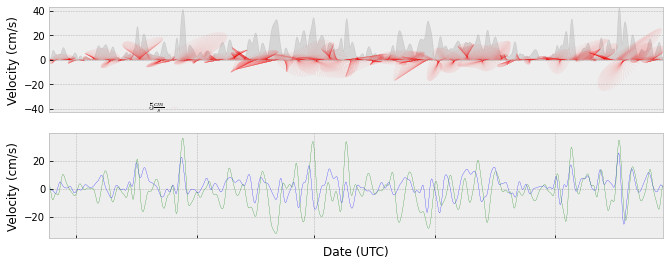

In [20]:
p1 = Timeseries1dStickPlot()
plt1, fig1 = p1.plot(timedata=data.index, 
                     udata=data.ufdata.values, 
                     vdata=data.vfdata.values,
                     rotate=0)
plt1.xlabel('test')
fig1.savefig('test_f35'+'.png',dpi=600)


#subsample
datasub=data.resample('24H').median()
p1 = Timeseries1dStickPlot()
plt1, fig1 = p1.plot(timedata=datasub.index, 
                     udata=datasub.ufdata.values, 
                     vdata=datasub.vfdata.values,
                     linescale=10,
                     rotate=0)
plt1.xlabel('test')
fig1.savefig('test_f35_12hr'+'.png',dpi=600)

p1 = Timeseries1dStickPlot()
plt1, fig1 = p1.plot(timedata=data.index, 
                     udata=data.udata.values, 
                     vdata=data.vdata.values,
                     rotate=0)
plt1.xlabel('test')
fig1.savefig('test_nofilter'+'.png',dpi=600)


### Loop through ADCP all sites

### Determine Mean, STD, Max value for each deployment

- from filtered data

M8 
- 2009/2012 ?
- no data in 2017 (failed instrument)
- 2018 not yet finalized

In [4]:
server_url='http://akutan.pmel.noaa.gov:8080/erddap'
dataset = 'ADCP_Mooring_16bsp8a_final'

e = ERDDAP(server=server_url)

df = pd.read_csv(e.get_search_url(response='csv', search_for='ADCP_Mooring and bsp8 and ADCP'))
print(df['Dataset ID'].values)

e.protocol = 'griddap'

opendap_url = e.get_download_url(
    dataset_id=dataset,
    response='opendap',
)

print(opendap_url)

['ADCP_Mooring_14bsp8a_final' 'ADCP_Mooring_16bsp8a_final'
 'ADCP_Mooring_18bsp8a_final' 'ADCP_Mooring_13bsp8a_final'
 'ADCP_Mooring_05bsp8b_final' 'ADCP_Mooring_08bsp8a_final'
 'ADCP_Mooring_05bsp8a_final' 'ADCP_Mooring_06bsp8a_final'
 'ADCP_Mooring_07bsp8a_final' 'ADCP_Mooring_11bsp8a_final'
 'ADCP_Mooring_10bsp8a_final' 'ADCP_Mooring_19bsp8a_final'
 'ADCP_Mooring_15bsp8a_final']
http://akutan.pmel.noaa.gov:8080/erddap/griddap/ADCP_Mooring_16bsp8a_final


ADCP_Mooring_05bsp8a_final
            ufdata       vfdata
count  1788.000000  1788.000000
mean      1.567465     0.242941
std       4.273652     4.201983
min     -18.065431   -14.987762
25%      -0.788245    -2.015015
50%       2.071055     0.597495
75%       4.000924     2.619546
max      14.072984    14.288246
ADCP_Mooring_05bsp8b_final
            ufdata       vfdata
count  1788.000000  1788.000000
mean      1.567465     0.242941
std       4.273652     4.201983
min     -18.065431   -14.987762
25%      -0.788245    -2.015015
50%       2.071055     0.597495
75%       4.000924     2.619546
max      14.072984    14.288246
ADCP_Mooring_06bsp8a_final
            ufdata       vfdata
count  1788.000000  1788.000000
mean      1.567465     0.242941
std       4.273652     4.201983
min     -18.065431   -14.987762
25%      -0.788245    -2.015015
50%       2.071055     0.597495
75%       4.000924     2.619546
max      14.072984    14.288246
ADCP_Mooring_07bsp8a_final
            ufdata       vfd

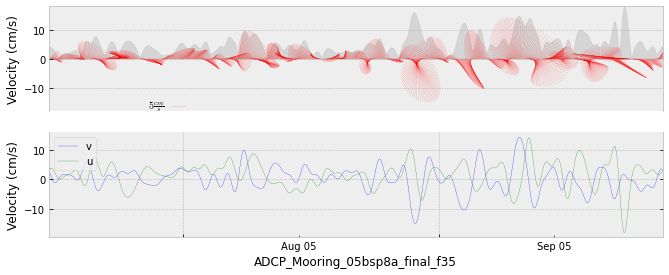

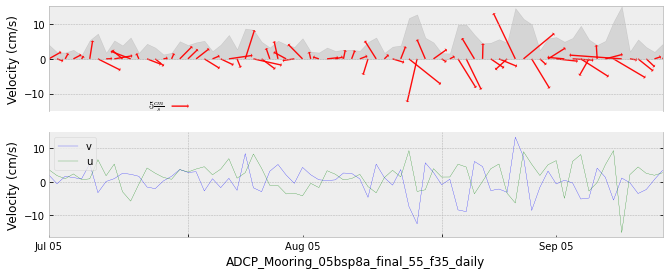

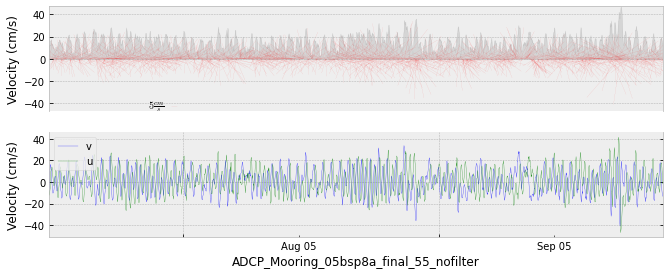

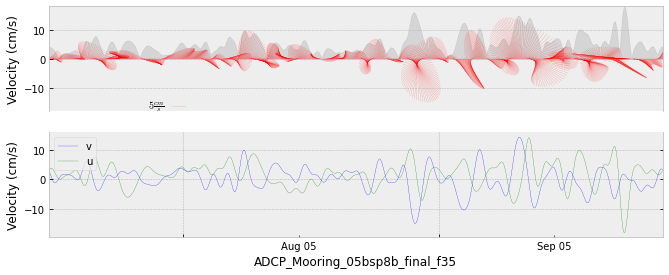

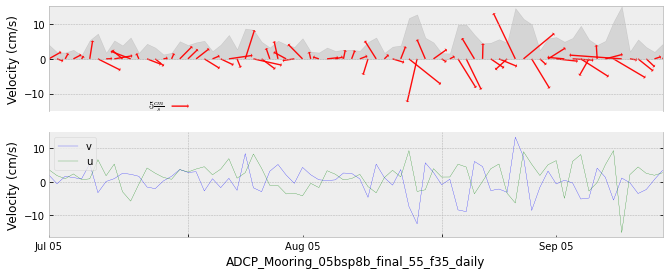

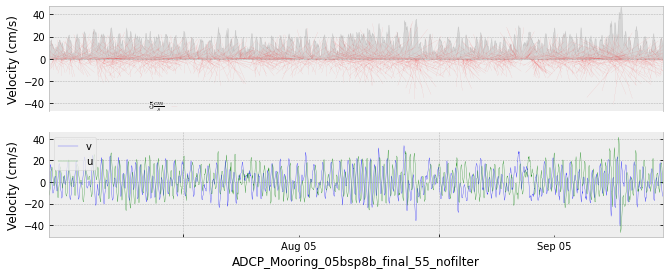

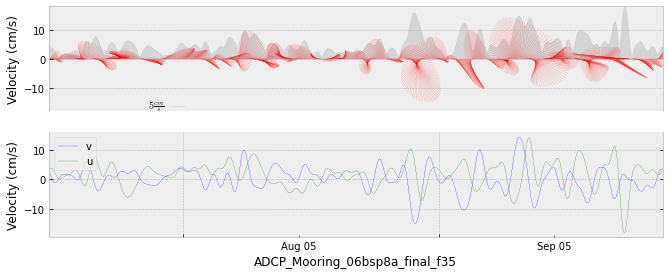

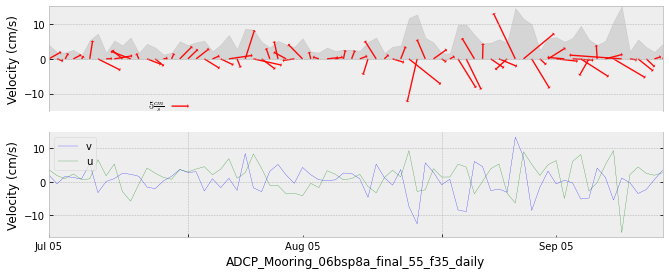

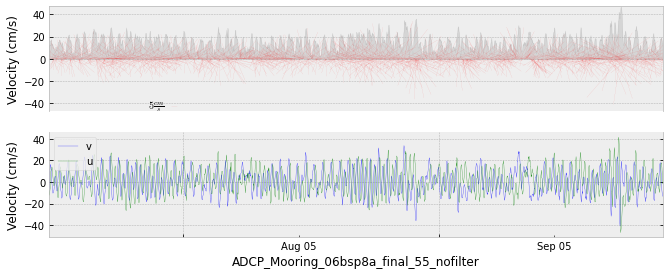

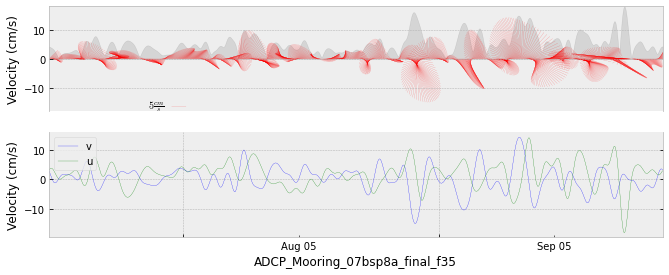

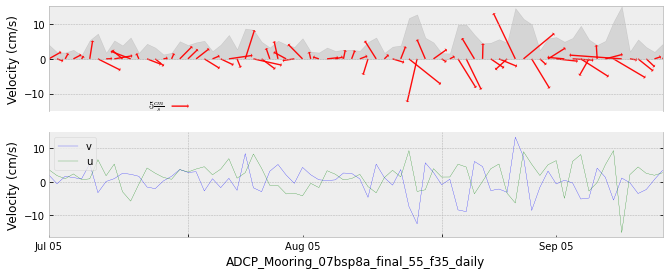

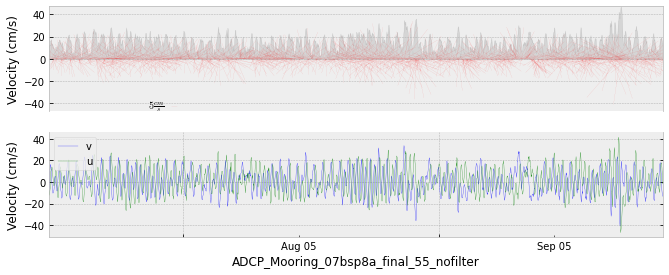

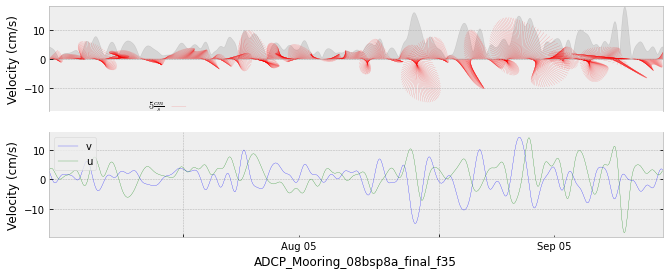

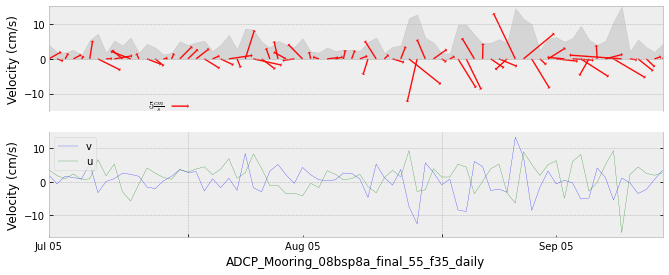

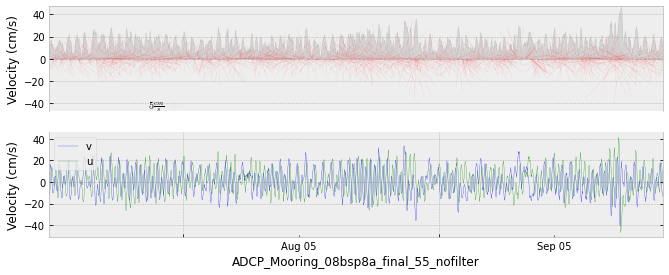

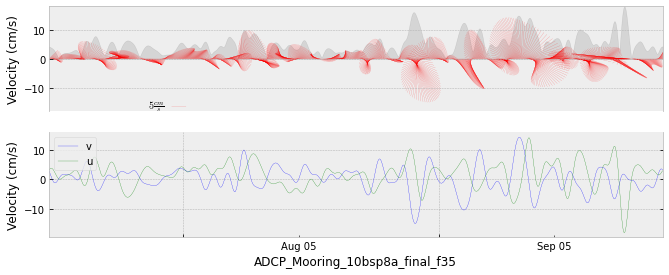

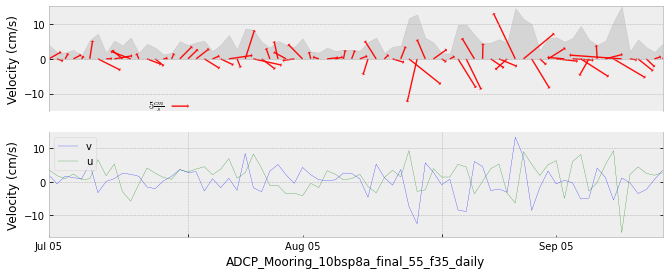

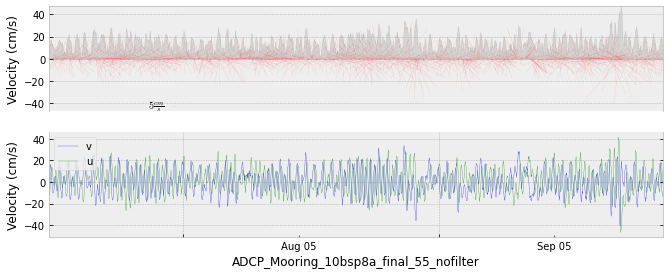

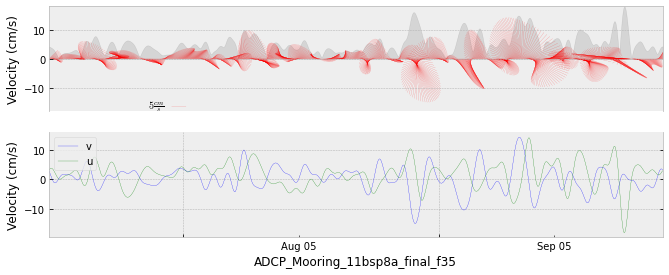

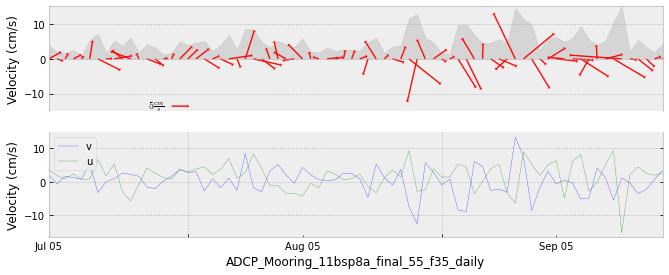

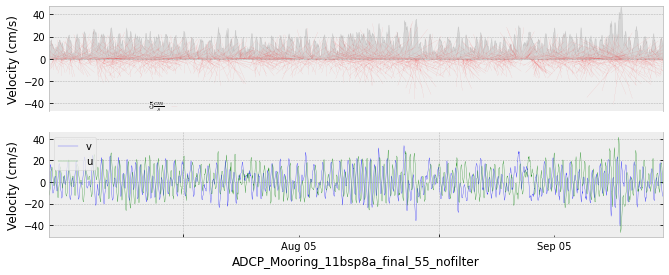

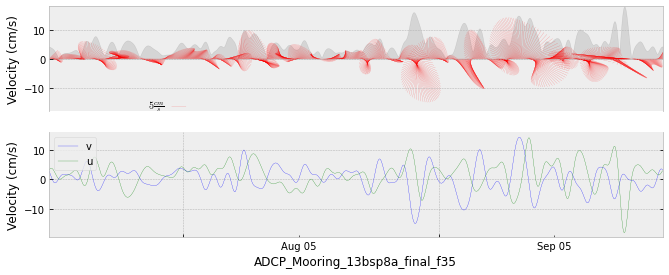

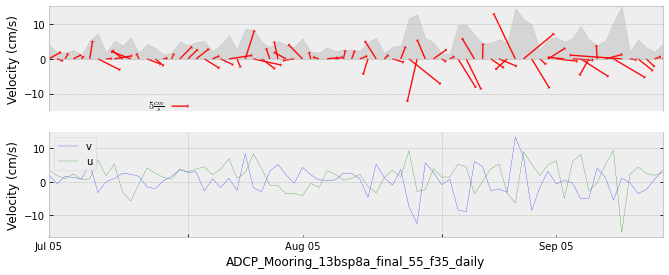

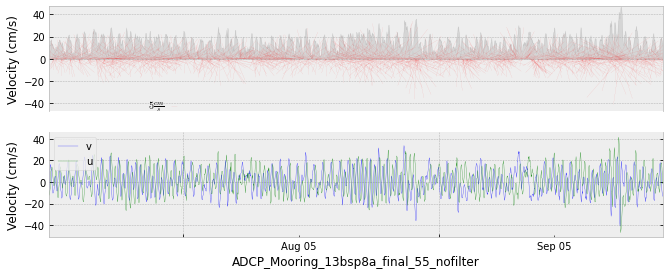

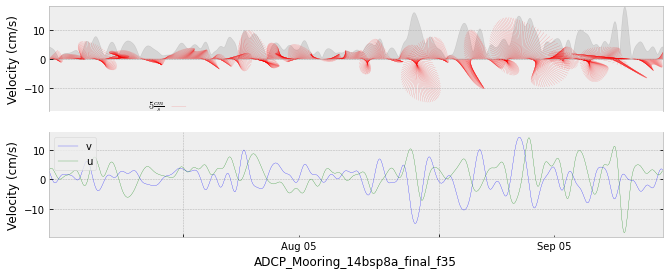

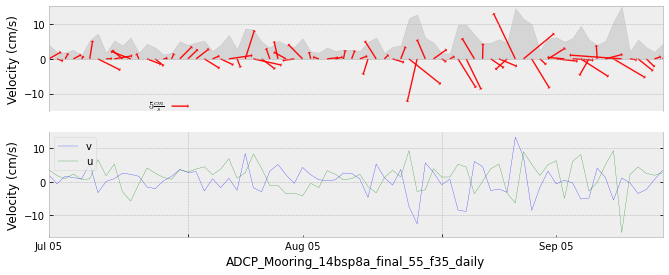

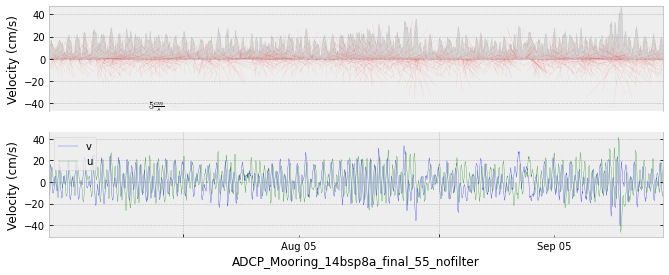

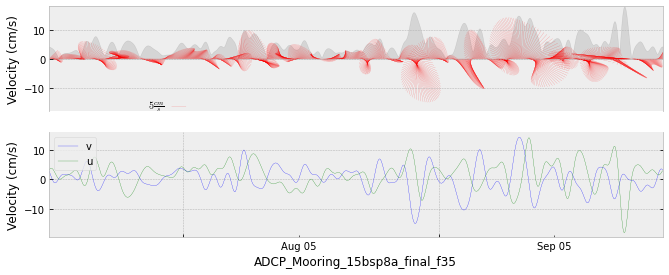

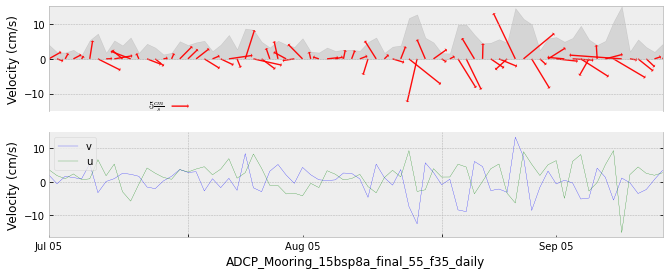

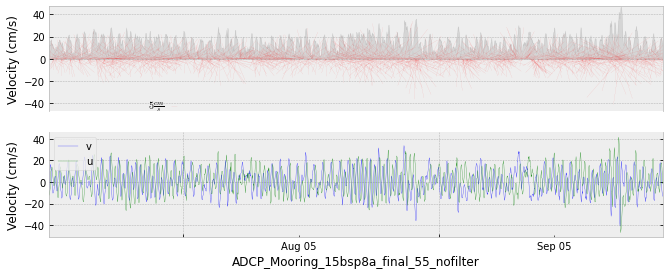

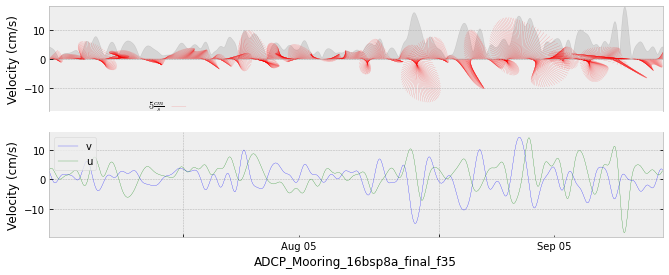

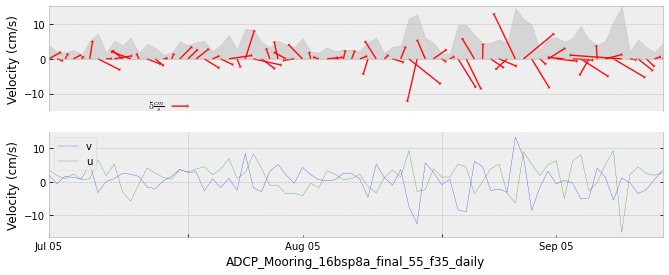

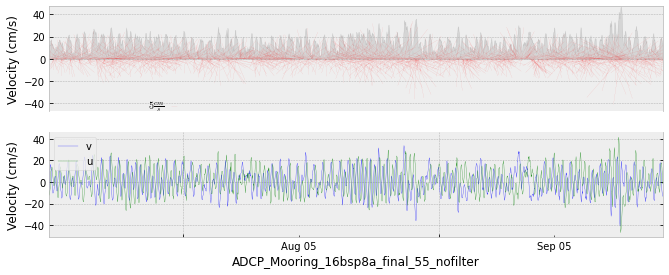

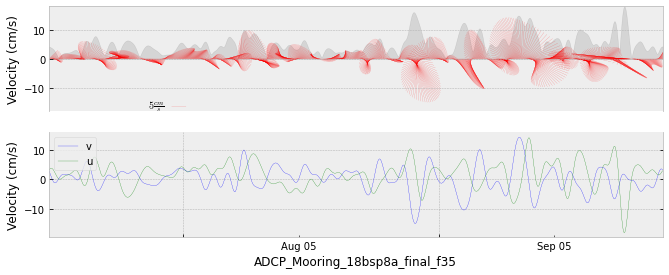

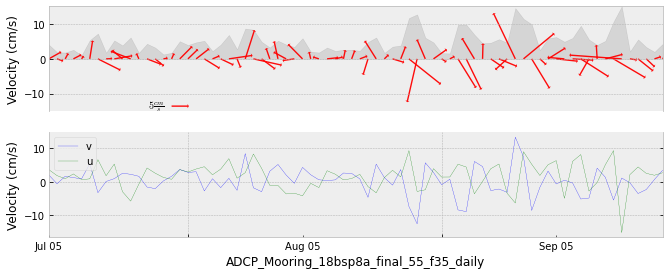

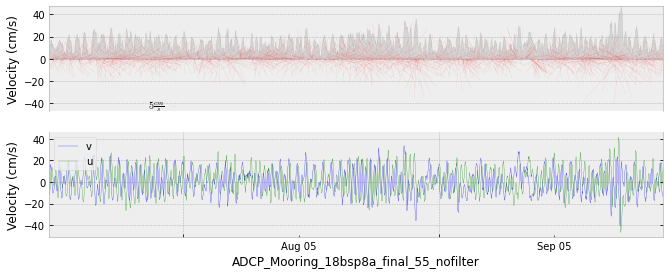

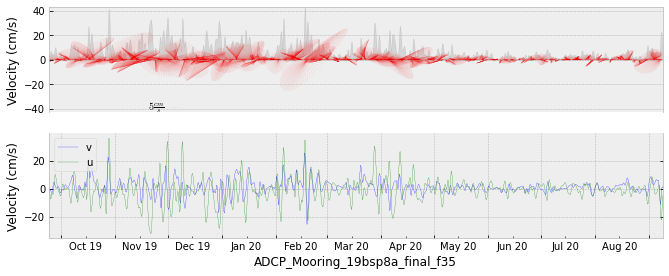

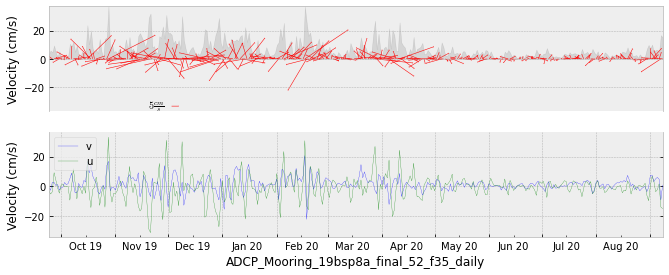

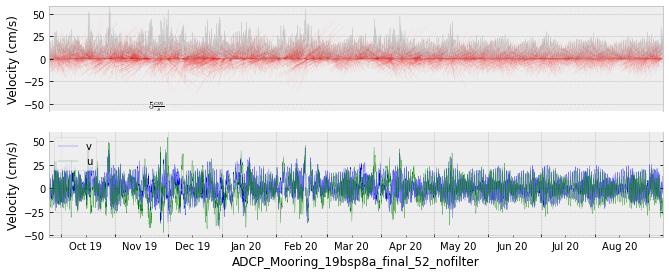

In [37]:
from requests.exceptions import HTTPError
import warnings
warnings.filterwarnings('ignore')

plotfigs = True
savedata = Faalse
domath = True

for dataset_id in sorted(df['Dataset ID'].values):
    try:
        e = ERDDAP(server=server_url,
            protocol='griddap',
            response='opendap'
        )
        e.constraints=None
        e.protocol = 'griddap'

        e.dataset_id=dataset_id
        e.response = 'nc'
        ds = e.to_xarray(decode_times=True)
    except:
        pass
    
    depth_curr = ds.isel(depth=ds.depth.size-2)
    
    ### dropna's to start (gets rid of any where all entries are gone)
    depth_curr = depth_curr.dropna(dim='time',how="all")
    
    ### filter
    try:
        udata = depth_curr.u_1205[:,0,0].to_pandas()
        vdata = depth_curr.v_1206[:,0,0].to_pandas()
    except:
        try:
            udata = depth_curr.ucomp_current[:,0,0].to_pandas()
            vdata = depth_curr.vcomp_current[:,0,0].to_pandas()
        except:
            udata = depth_curr.u_curr_comp[0,0,:].to_pandas()
            vdata = depth_curr.v_curr_comp[0,0,:].to_pandas()

    data = pd.concat([udata, vdata], axis=1)
    data.columns = ['udata','vdata']


    data['udata'][data.udata > 1e34]=np.nan
    data['vdata'][data.vdata > 1e34]=np.nan
    data = data.resample('1H').mean()

    ## missing data fill limited by number of hours to linearly interpolate
    data['tempu'] = data['udata'].interpolate(method='time',limit=6)
    data['tempv'] = data['vdata'].interpolate(method='time',limit=6)

    # get index of missing data that wasn't filled
    # the remaining missing data will continue to be missing after analysis
    # this data and the edges of the timeseries need to have the effects of the filter window accounted for

    missing_index_u = np.isnan(data.tempu)
    missing_index_v = np.isnan(data.tempv)
    data['tempu'] = data['udata'].interpolate(method='time')
    data['tempv'] = data['vdata'].interpolate(method='time')

    #filter data with rudimentary matlab script
    data['ufdata'] = lanzcos.lanzcos(data.tempu.values,1,35)+data['udata'].mean()
    data['vfdata'] = lanzcos.lanzcos(data.tempv.values,1,35)+data['vdata'].mean()
    data['ufdata'][missing_index_u] = np.nan
    data['vfdata'][missing_index_v] = np.nan    

    #data['depth'] = depth_curr.depth.values
    data['depth'] = ds.isel(depth=ds.depth.size-2).depth.values

    #extra calculations
    if domath:
        print(dataset_id)
        print(data.describe()[['ufdata','vfdata']])
        
    #plot
    if plotfigs:
        p1 = Timeseries1dStickPlot()
        plt1, fig1 = p1.plot(timedata=data.index, 
                             udata=data.ufdata.values, 
                             vdata=data.vfdata.values,
                             rotate=0)
        plt1.xlabel(dataset_id+'_f35')
        fig1.savefig(dataset_id+'_'+str(int(data['depth'].values[0]))+'_f35'+'.png',dpi=600)


        #subsample
        datasub=data.resample('D').median()
        p1 = Timeseries1dStickPlot()
        plt1, fig1 = p1.plot(timedata=datasub.index, 
                             udata=datasub.ufdata.values, 
                             vdata=datasub.vfdata.values,
                             linescale=10,
                             rotate=0)
        plt1.xlabel(dataset_id+'_'+str(int(data['depth'].values[0]))+'_f35_daily')
        fig1.savefig(dataset_id+'_'+str(int(data['depth'].values[0]))+'_f35_daily'+'.png',dpi=600)

        p1 = Timeseries1dStickPlot()
        plt1, fig1 = p1.plot(timedata=data.index, 
                             udata=data.udata.values, 
                             vdata=data.vdata.values,
                             rotate=0)
        plt1.xlabel(dataset_id+'_'+str(int(data['depth'].values[0]))+'_nofilter')
        fig1.savefig(dataset_id+'_'+str(int(data['depth'].values[0]))+'_nofilter'+'.png',dpi=600)
        
    #save data
    if savedata:
        data[['depth','ufdata','vfdata']].to_csv(dataset_id+'_'+str(int(data['depth'].values[0]))+'_f35'+'.csv')

## Backscatter from EIN files (not on erddap)

In [17]:
einfiles = '/Users/bell/ecoraid/2017/Moorings/17bsp2b/erddap/final_data/17bsp2b_wcp_ein.cf.nc'
xdf = xr.load_dataset(einfiles)

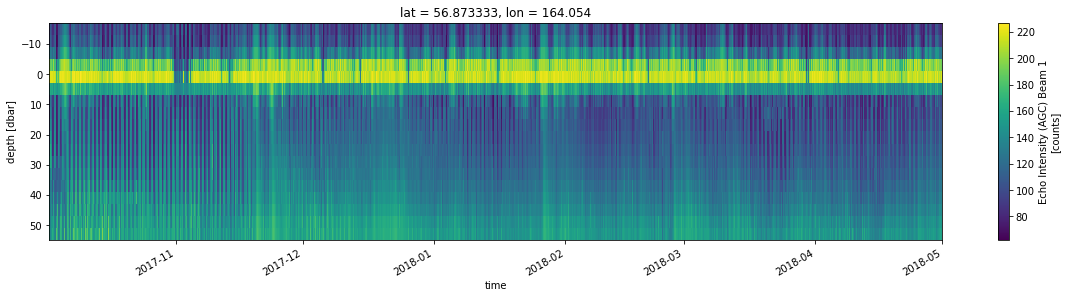

In [20]:
fig, ax = plt.subplots(figsize=(20, 4))
xdf.AGC1_1221.T.plot(ax=ax)
ax.invert_yaxis()

(17501.0, 17531.0)

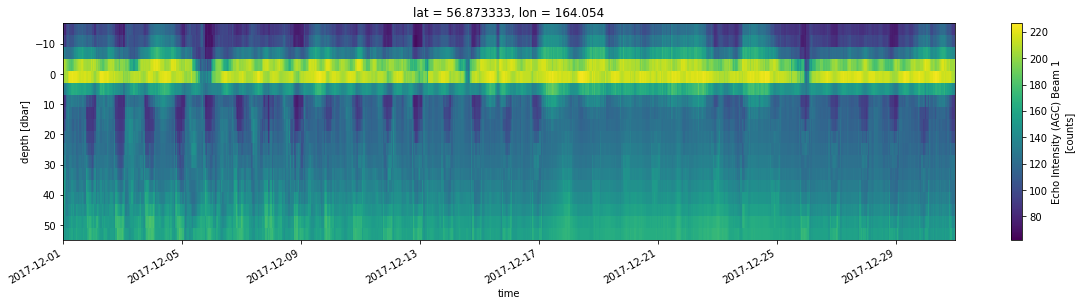

In [26]:
fig, ax = plt.subplots(figsize=(20, 4))
xdf.AGC1_1221.T.plot(ax=ax)
ax.invert_yaxis()
ax.set_xlim([datetime.date(2017,12,1),datetime.date(2017,12,31)])

(17631.0, 17638.0)

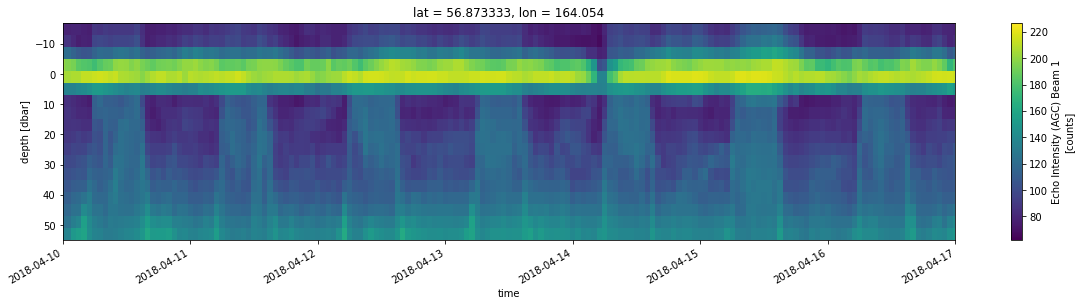

In [29]:
fig, ax = plt.subplots(figsize=(20, 4))
xdf.AGC1_1221.T.plot(ax=ax)
ax.invert_yaxis()
ax.set_xlim([datetime.date(2018,4,10),datetime.date(2018,4,17)])